# Introduction

Key takeaways
* Installing packages
* Handling data with pandas
* Unzipping Files with Python
* Using seaborn for vizualization
* Using matplotlib for vizualization
* Creating Lambda functions
* Deploying machine learning models
* Evaluating machine learning results
* Validating aggregates

# The CRISP-DM Process

For this project, I will be following the CRISP-DM (Cross-industry standard process for data mining) process.

![alt text](https://codesachin.files.wordpress.com/2015/09/crisp-dm.gif)
The process follows these steps:
    1. Pick a dataset
    2. Generate business questions
    3. Obtain data understanding
    4. Prepare the data
    5. Analyze, Model, and Visualize
    6. Evaluate your analysis
    7. Communicate business insights   
 
 
    
This project approaches these steps in the following way:
    1. Boston & Seattle Airbnb Open Data 
    2. I am starting with these business questions.
        a. What is the mission of Airbnb?
        b. What is more likely to cause bad reviews?
        c. What is the cost of bad reviews?
        d. What is the value of good reviews?
    3. Steps 3 to 6 will be conducted using a Jupyter notebook, and some Python 3 magic!

# Data Handling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def unzip_files(zip_filename_list, folder=None):
    """
    Unzipping the datasets
    """
    folder_names = []
    for file in zip_filename_list:
        
        # paths
        filename_path = os.path.join('data', file)
        folder_name = filename_path[:-4].replace("-", "_")
        
        # extracting
        try:
            zip_ref = ZipFile(filename_path)
            zip_ref.extractall(folder_name)
            zip_ref.close()
        except:
            print('File already extracted!')
        
        # appending folder names
        if filename_path.find('.') >= 0:
            folder_names.append(folder_name)
        
    return folder_names

In [3]:
def read_concat(folder_names, target_file_name):
    """
    Reading files of different folders with same naming convention
    """
    df_con = pd.DataFrame()
    for folder in folder_names:
        target = os.path.join(folder, target_file_name)
        df = pd.read_csv(target)
        df['rowsource'] = target
        
        df_con = pd.concat([df_con, df], axis=0, sort=True).reset_index(drop=True)
    return df_con

## - Extracting Data

In [4]:
# getting zip file names
data_zip = os.listdir('data')
data_zip

['boston-airbnb-open-data.zip',
 'boston_airbnb_open_data',
 'extra_seattle',
 'seattle',
 'seattle.zip']

In [5]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

File already extracted!
File already extracted!
File already extracted!


['data\\boston_airbnb_open_data', 'data\\seattle']

In [6]:
[os.listdir(folder_name) for folder_name in folder_names]

[['calendar.csv', 'listings.csv', 'reviews.csv'],
 ['calendar.csv', 'listings.csv', 'reviews.csv']]

## - Importing Data

---
First, we are importing the calendar dataset.

In [7]:
calendar = read_concat(folder_names, 'calendar.csv')

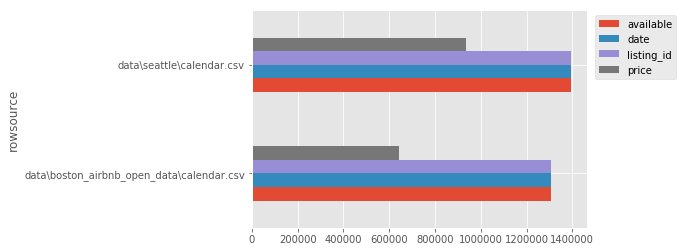

In [8]:
calendar.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');

---
Second, we are importing the listings dataset.

In [9]:
listings = read_concat(folder_names, 'listings.csv')

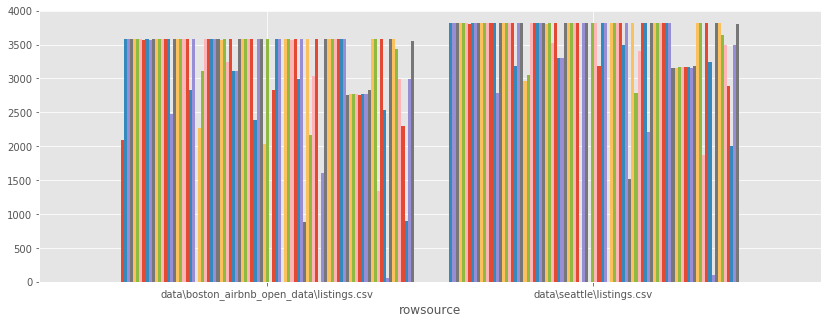

In [10]:
listings\
    .groupby('rowsource')\
    .count()\
    .plot.bar(legend=False, figsize=(14, 5), rot=0, width=.9);

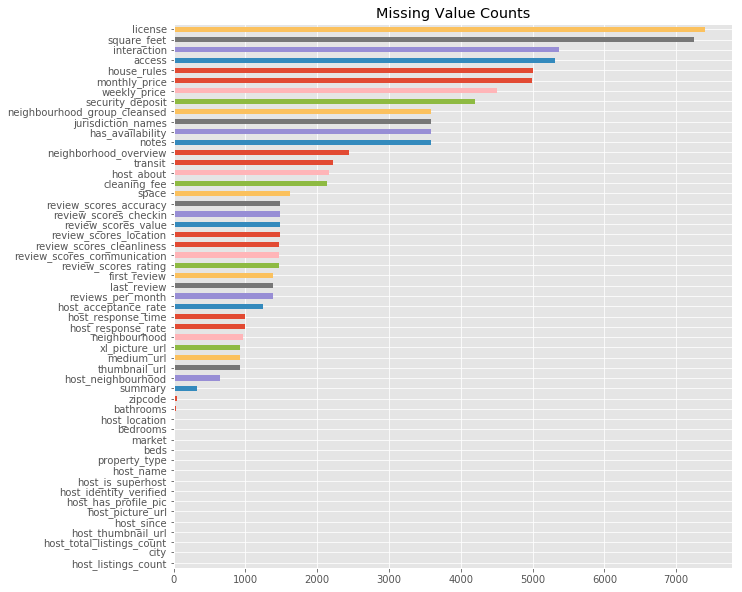

In [11]:
listing_nulls = listings.isnull().sum()\
    .where(lambda x: x>0)\
    .dropna()\
    .sort_values(ascending=True)

listing_nulls\
    .plot.barh(figsize=(10, 10), title="Missing Value Counts");

In [12]:
listings.shape

(7403, 96)

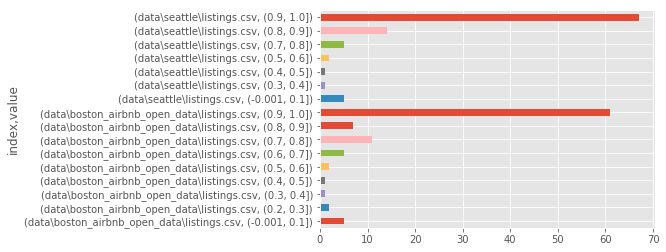

In [13]:
non_complete_listings = listings.groupby('rowsource')\
    .count()\
    .div(listings.rowsource.value_counts(), axis=0)\
    .reset_index()\
    .melt(id_vars='index')

non_complete_listings\
    .groupby(['index', pd.cut(non_complete_listings.value, bins=10)])\
    .size()\
    .plot.barh();

---
Third, we are importing the reviews dataset.

In [14]:
reviews = read_concat(folder_names, 'reviews.csv')

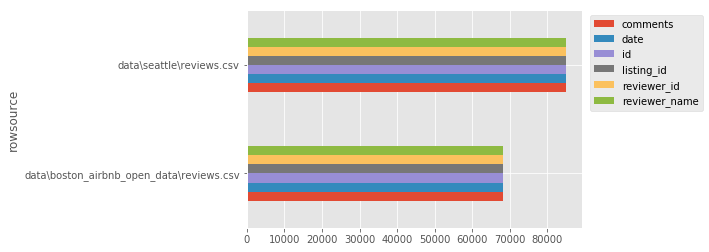

In [15]:
reviews.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');

**Data Import Findings:**
* It is clear that calendar has missing prices.
* It is clear that there are multiple columns with missing values on both datasets.
* On the contrary, reviews are all complete.

## Data Handling: Data Understanding

### <li> Data Understanding: Calendar

In [16]:
# calendar first 5 lines
calendar.head()

,available,date,listing_id,price,rowsource
0,f,2017-09-05,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
1,f,2017-09-04,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
2,f,2017-09-03,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
3,f,2017-09-02,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
4,f,2017-09-01,12147973,NaN,data\boston_airbnb_open_data\calendar.csv


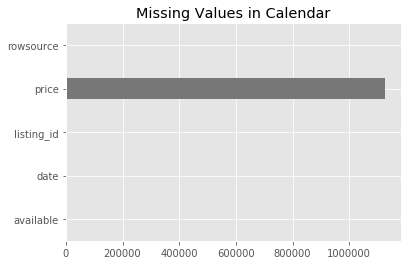

In [17]:
calendar.isnull().sum().plot.barh(title="Missing Values in Calendar");

#### Calendar: Available Feature

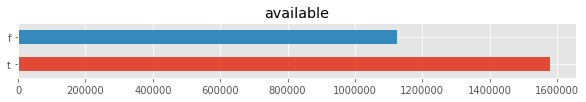

In [18]:
calendar.available.value_counts().plot.barh(figsize=(10, 1), title='available');

#### Calendar: Price Feature

In [19]:
calendar.price.unique()

array([nan, '$65.00', '$75.00', ..., '$10.00', '$24.00', '$817.00'],
      dtype=object)

In [20]:
# Data conversions
calendar.price = calendar.price.str.replace('$', '')
calendar.price = calendar.price.str.replace(',', '').astype(float)
calendar.date = pd.to_datetime(calendar.date)

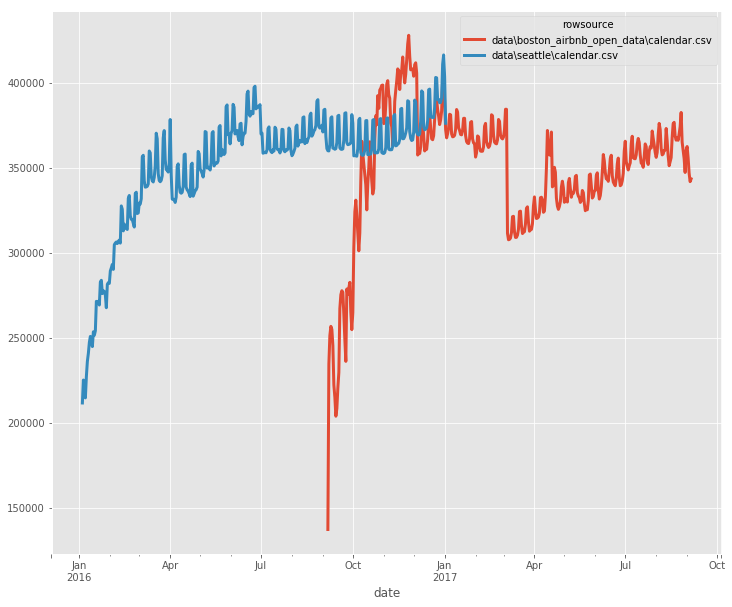

In [21]:
calendar.groupby(['rowsource', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='rowsource', values='price')\
    .plot.line(figsize=(12, 10), lw=3);

In [22]:
calendar['nan_grp'] = calendar.price.fillna('MissingValue')

In [23]:
calendar.loc[calendar.nan_grp!='MissingValue', 'nan_grp'] = 'ProvidedValue'

In [24]:
calendar['source_grp'] = calendar.rowsource.str.cat(calendar.nan_grp, sep=' - ')

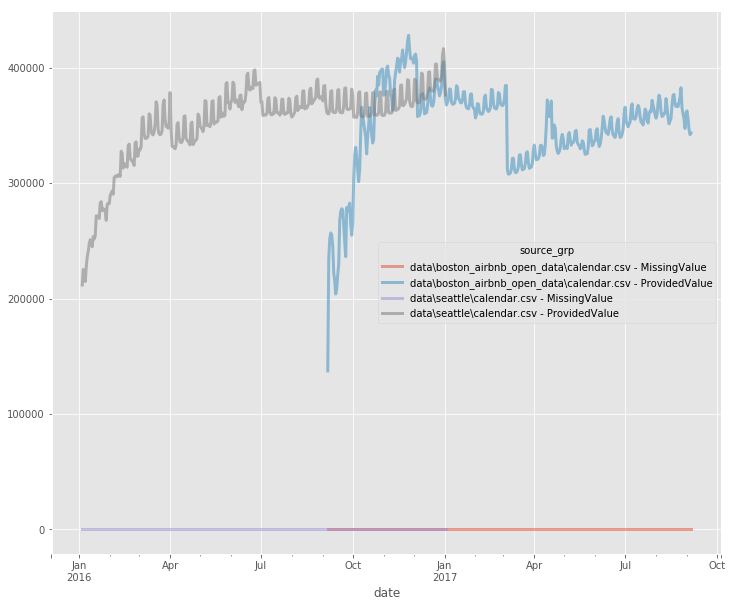

In [25]:
calendar.groupby(['source_grp', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='source_grp', values='price')\
    .plot.line(figsize=(12, 10), lw=3, alpha=.5);

In [26]:
calendar.groupby('source_grp').agg({'date': ['min', 'max']})

date           
                                                          min        max
source_grp                                                              
data\boston_airbnb_open_data\calendar.csv - Mis... 2016-09-06 2017-09-05
data\boston_airbnb_open_data\calendar.csv - Pro... 2016-09-06 2017-09-05
data\seattle\calendar.csv - MissingValue           2016-01-04 2017-01-02
data\seattle\calendar.csv - ProvidedValue          2016-01-04 2017-01-02

In [27]:
month_func = lambda x: x.month
delta_month_func = lambda x: x.max_date.shift(1).apply(month_func)- x.max_date.apply(month_func)
delta_days_func = lambda x: x.max_date.shift(1)- x.max_date

calendar.groupby('rowsource').agg({'date': 'max'})\
    .rename(columns={'date':'max_date'})\
    .assign(delta_month=delta_month_func,
            delta_days=delta_days_func)\
    .fillna('')

,max_date,delta_month,delta_days
rowsource,,,
data\boston_airbnb_open_data\calendar.csv,2017-09-05,,
data\seattle\calendar.csv,2017-01-02,8,246 days 00:00:00


**Calendar Data Findings:**

Informational:
* Records of availability and price at a date and listing id level.
* Only missing values are in prices. Some listings have no prices.
* Dates of datasets do not match.
    * It seems that seattle was service before boston.
    * Seattle has no data from 2017-01-02 to 2017-09-05, 8 months or 246 days.
Transformation:
* Prices have to be cleaned. They include $ sign and comma separators.

### <li> Data Understanding: Listings

In [28]:
missing_pct = listings.isnull().sum()/listings.shape[0]

#### Listings: Object Features

In [29]:
# listings first 5 lines
pd.options.display.max_rows = 100
listings.select_dtypes(include=object).dropna(axis=0, how='all').sample(2).T\
    .merge(missing_pct.to_frame('missing'), left_index=True, right_index=True, how='left')\
    .iloc[:, [2,0,1]].sort_values('missing', ascending=False).style.bar()

,missing,5347,6930
interaction,0.725652,nan,nan
access,0.716872,nan,nan
house_rules,0.676753,nan,nan
monthly_price,0.675132,nan,"$2,500.00"
weekly_price,0.608132,$270.00,$800.00
security_deposit,0.566662,nan,nan
jurisdiction_names,0.484263,WASHINGTON,WASHINGTON
neighbourhood_group_cleansed,0.484263,West Seattle,Other neighborhoods
has_availability,0.484263,t,t
notes,0.483723,Parking is on the street.,"LGBT friendly space - No judgement household. Owner has cat, chickens and black lab. When booking with Airbnb we will want 3-4 verifications. One of them must be an offline ID verification. If you are booking in the summer months - please note, we do not have air conditioning, but we do have 3 fans in the space. Seattle doesn't usually get that hot - but this summer has been exceptionally hot."


#### Listings: Non-Object Features

In [30]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T\
    .merge(missing_pct.to_frame('missing'), left_index=True, right_index=True, how='left')\
    .iloc[:, [-1, 0, 1, 2, 3]]\
    .sort_values('missing', ascending=False)\
    .style.format("{:2,.2f}").bar(subset=['missing'])

,missing,6640,1026,2405,6465
license,1.00,nan,nan,nan,nan
square_feet,0.98,nan,nan,nan,nan
review_scores_accuracy,0.20,10.00,10.00,10.00,10.00
review_scores_checkin,0.20,10.00,10.00,10.00,10.00
review_scores_value,0.20,10.00,9.00,9.00,9.00
review_scores_location,0.20,10.00,9.00,9.00,10.00
review_scores_cleanliness,0.20,10.00,10.00,10.00,10.00
review_scores_communication,0.20,10.00,10.00,10.00,10.00
review_scores_rating,0.20,100.00,93.00,93.00,98.00
reviews_per_month,0.19,2.21,1.54,0.21,3.88


### <li> Data Understanding: Reviews

In [31]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


### <li> Data Understanding: Id Relationships

In [32]:
len_func = lambda x: x.str.len()

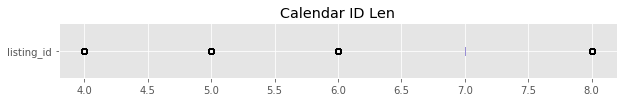

In [33]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

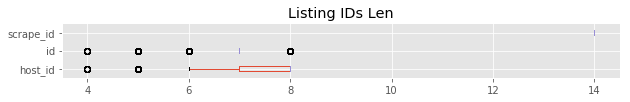

In [34]:
listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

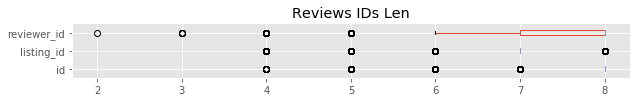

In [35]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

**Id Relationships Findings**
* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so therefore si irrelevant for the analysis.
* The host_id in the listing dataset seems to be related to the reviewer_d of the reviews dataset.
* Given that there are reviewer-ids with length of 2 and 3 in the reviwers dataset and not in the listings dataset, we can assume that the listings don't inlcude stays (missing records) for those host with 2 and 3 lenght-ids, but those host have reviews for the listings in the reviewer dataset.

### <li> Data Understanding: Granularity of Datasets

#### Calendar Granularity

In [36]:
duplicates = calendar.groupby(['date', 'listing_id', 'rowsource', 'available'])\
    .size().to_frame('duplicates').query("duplicates>1").head()

In [37]:
calendar_price_dups = duplicates.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {calendar_price_dups}")

These are the id of price duplicates: 
 12898806


##### <ol> Examples of Calendar Duplicates

In [38]:
filter_cond = (calendar.listing_id == 12898806)
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

,available,date,listing_id,price,rowsource,nan_grp,source_grp
748850,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748873,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748849,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748872,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748848,t,2016-09-08,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...


> Duplicates on one listing_id.

#### Listing Granularity

In [39]:
listings.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


In [40]:
listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

,calendar_last_scraped,first_review,host_since,last_review,last_scraped
0,2016-09-06,NaT,2015-04-15,NaT,2016-09-07
1,2016-09-06,2014-06-01,2012-06-07,2016-08-13,2016-09-07
2,2016-09-06,2009-07-19,2009-05-11,2016-08-05,2016-09-07
3,2016-09-06,2016-08-28,2013-04-21,2016-08-28,2016-09-07
4,2016-09-06,2015-08-18,2014-05-11,2016-09-01,2016-09-07


> No duplicates. Granulated by listing. Aggregated dates (first, last, since).

#### Reviews Granularity

In [41]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


In [42]:
reviews_duplicated = reviews\
    .groupby(['listing_id', 'reviewer_id', 'date'])\
    .size()\
    .to_frame("duplicates")\
    .query("duplicates>1")\
    .reset_index()
reviews_duplicated.style.bar(subset=['duplicates'])

,listing_id,reviewer_id,date,duplicates
0,447523,35607120,2015-07-06,2
1,568234,16199611,2014-09-08,2
2,1173306,8492099,2013-09-06,2
3,1529321,30877683,2015-05-15,2
4,3533224,39668556,2015-12-01,2
5,3866526,63239764,2016-03-18,2
6,3897963,47193495,2016-04-07,2
7,3897995,39441871,2016-03-23,2
8,3901439,9618964,2016-03-24,2
9,4402209,63239764,2016-03-25,2


##### <ol> Examples of Reviews Duplicates

In [43]:
reviews.merge(reviews_duplicated.drop('duplicates', axis=1),
              on=['listing_id', 'reviewer_id', 'date'], 
              how='left',
              indicator=True)\
    .query("_merge=='both'").head(6)\
    .style.background_gradient(subset=['reviewer_id'])

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource,_merge
6558,Nice neighborhood with a lot of local life and restaurants. Check in was simple and I was never bothered.,2015-05-15,32216803,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
6559,"A+ treatment all the way, you are an adult in a friendly part of town. Nice room and choice of two bathrooms.",2015-05-15,32223055,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
29370,The reservation was canceled 23 days before arrival. This is an automated posting.,2014-09-08,19256952,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
29371,The reservation was canceled 24 days before arrival. This is an automated posting.,2014-09-08,19256954,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
30826,My night at Aris house was perfect yet again! Thank you so much for hosting me Ari!!,2016-03-25,66858887,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both
30827,"The hosts communication was great, the listing was exactly as described definitely stay at Aris house if you need a place in Boston.",2016-03-25,66963792,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both


> Granulated at the listing_id, reviewer_id, and date level. Some duplicates by automation. Some manual duplicates by reviewer with different commets for same date and listing.

**Granularity Findings**
* The calendar dataset is granulated at the date, listing_id level.
    * This dataset has duplicates for listing_id 12898806.
* The listings dataset is granulated at the id level.
    * No duplicates.
* The reviews dataset is granulated at the date, listing_id, reviewer_id level.
    * This dataset has some meaningful duplicates made by the reviewer and some automated duplicates.

### <li> Data Understanding: Testing Relationships

#### Relationship Between Null Prices at calendar_last_scraped

In [44]:
listing_sample = calendar[~calendar.price.isna()].sample(200).listing_id.unique()[:100]
print(f"Sampled {len(listing_sample)} listing ids.")

Sampled 100 listing ids.


In [45]:
calendar_sample = calendar.query(f"listing_id == {list(listing_sample)}")

In [46]:
airbnb_evaluation = calendar_sample.merge(listings,
                      left_on='listing_id',
                      right_on='id',
                      how='inner',
                      suffixes=['', '_last'])
airbnb_evaluation.calendar_last_scraped = pd.to_datetime(airbnb_evaluation.calendar_last_scraped)

In [47]:
listings.columns[listings.columns.str.contains('last')]

Index(['calendar_last_scraped', 'last_review', 'last_scraped'], dtype='object')

In [48]:
# attempting to create relationship between null prices price at calendar_last_scraped
airbnb_evaluation[['listing_id', 'price', 'price_last', 'date', 'calendar_last_scraped']]\
    .query("date==calendar_last_scraped").head()

,listing_id,price,price_last,date,calendar_last_scraped
364,14057466,NaN,$150.00,2016-09-06,2016-09-06
729,3730447,NaN,$200.00,2016-09-06,2016-09-06
1094,12932001,NaN,$300.00,2016-09-06,2016-09-06
1459,5222368,NaN,$75.00,2016-09-06,2016-09-06
1824,7630346,NaN,$109.00,2016-09-06,2016-09-06


> **Findings**: No relationship. We cannot inputate using this method.

#### Testing Merge with rowsource and Geographical Columns

In [49]:
geo_columns = list(airbnb_evaluation\
                    .select_dtypes(include=object)\
                    .columns[-10:][:-6]\
                    .drop(['space', 'street']))+['rowsource']

In [50]:
airbnb_evaluation[geo_columns].groupby(geo_columns).size()

smart_location             state  rowsource                                
Boston, MA                 MA     data\boston_airbnb_open_data\calendar.csv    11680
Charlestown, MA            MA     data\boston_airbnb_open_data\calendar.csv      365
Jamaica Plain, Boston, MA  MA     data\boston_airbnb_open_data\calendar.csv      365
Jamaica Plain, MA          MA     data\boston_airbnb_open_data\calendar.csv      365
Mattapan, MA               MA     data\boston_airbnb_open_data\calendar.csv      365
Seattle, WA                WA     data\seattle\calendar.csv                    23360
dtype: int64

> **Findings**: Merging was succesful at the listing_id and id level. We still have to check the integrity of the data on mergin. Were there duplicates introduced?

#### Looking for Meaningful Relationship Between Listing and Reivews

In [51]:
airbnb_evaluation.filter(regex='revi|id').head()

,listing_id,first_review,host_id,host_identity_verified,id,last_review,number_of_reviews,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,scrape_id
0,14057466,2016-08-03,30314324,f,14057466,2016-08-14,2,10.0,10.0,10.0,10.0,10.0,90.0,9.0,1.67,20160906204935
1,14057466,2016-08-03,30314324,f,14057466,2016-08-14,2,10.0,10.0,10.0,10.0,10.0,90.0,9.0,1.67,20160906204935
2,14057466,2016-08-03,30314324,f,14057466,2016-08-14,2,10.0,10.0,10.0,10.0,10.0,90.0,9.0,1.67,20160906204935
3,14057466,2016-08-03,30314324,f,14057466,2016-08-14,2,10.0,10.0,10.0,10.0,10.0,90.0,9.0,1.67,20160906204935
4,14057466,2016-08-03,30314324,f,14057466,2016-08-14,2,10.0,10.0,10.0,10.0,10.0,90.0,9.0,1.67,20160906204935


In [52]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


> **Findings**: There was no meaninful relationship related to the business questions. The listings already have ratings in it. Therefore, I don't see the need for sentiment analysis here.  Thus, this dataset will be ingored for the rest of the analysis.

## Data Handling: Preparing Data for Analysis

In [53]:
# column additions fro scatter and monthly comparisons
calendar['date_num'] = calendar.date.rank(method='dense')
calendar['month_name'] = calendar.date.apply(lambda x: x.month_name())
max_date = str(calendar.date.max().date())
min_date = str(calendar.date.min().date())

### <li> Preparing Data for Analysis: Calendar Null Analysis

#### Nan Price Removal Impact

In [54]:
calendar.groupby('nan_grp').size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum()*100)

,row_count,pct_total
nan_grp,,
MissingValue,1124881,41.624335
ProvidedValue,1577579,58.375665


In [55]:
def null_bar_by(column):
    calendar.groupby([column, 'nan_grp']).size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum()*100)\
        .reset_index().query("nan_grp=='MissingValue'")\
        .plot.barh(x=column, y='pct_total', 
                   legend=False, figsize=(10, 4),
                   title=f"Missing Prices from {min_date} to {max_date}");
    plt.xlabel('% Missing Prices of Grand Total');

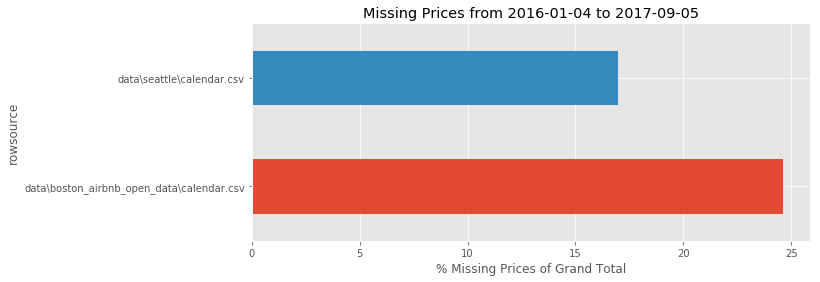

In [56]:
null_bar_by('rowsource')

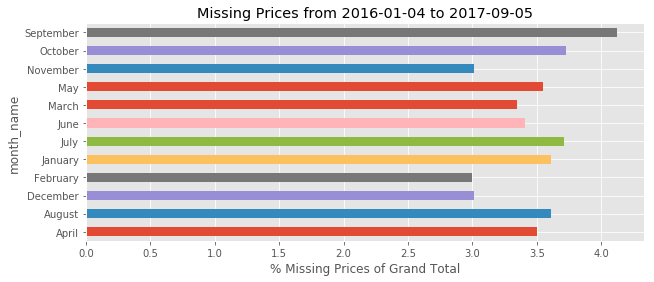

In [57]:
null_bar_by('month_name')

In [58]:
calendar_price_bymonth = calendar.reset_index(drop=True)\
    .pivot(columns='month_name', values='price')

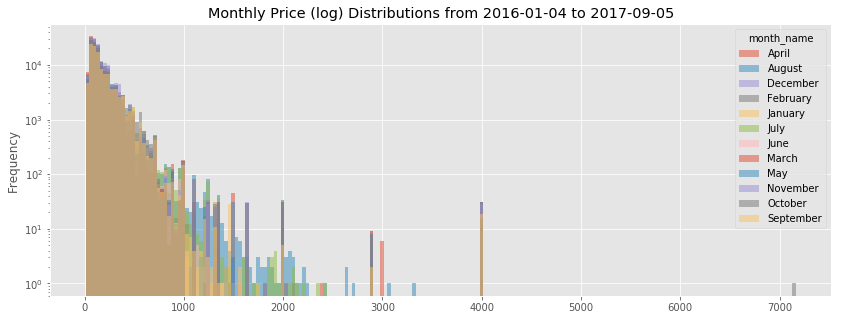

In [59]:
calendar_price_bymonth\
    .plot.hist(bins=200, 
               figsize=(14, 5), 
               logy=True,
               alpha=.5,
               title=f'Monthly Price (log) Distributions from {min_date} to {max_date}');

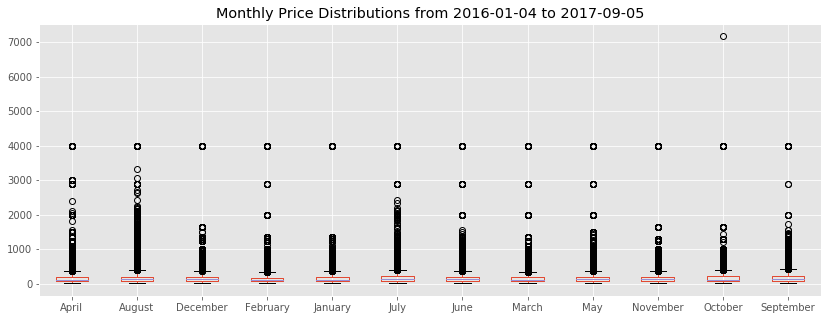

In [60]:
calendar_price_bymonth\
    .plot.box(figsize=(14, 5),
              title=f'Monthly Price Distributions from {min_date} to {max_date}');

In [61]:
calendar_price_bysource = calendar.reset_index(drop=True)\
    .pivot(columns='rowsource', values='price')

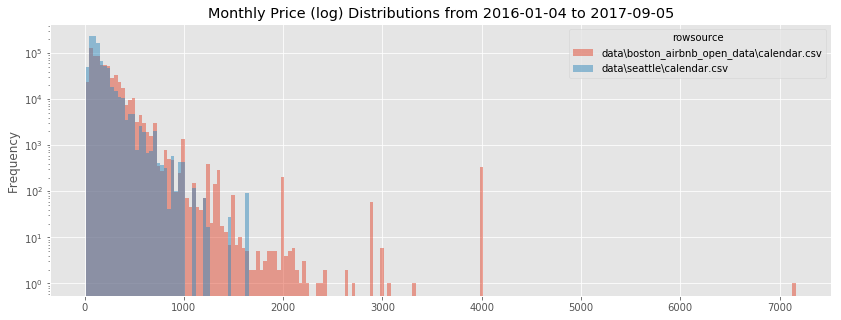

In [62]:
calendar_price_bysource\
    .plot.hist(bins=200, 
               figsize=(14, 5), 
               logy=True,
               alpha=.5,
               title=f'Monthly Price (log) Distributions from {min_date} to {max_date}');

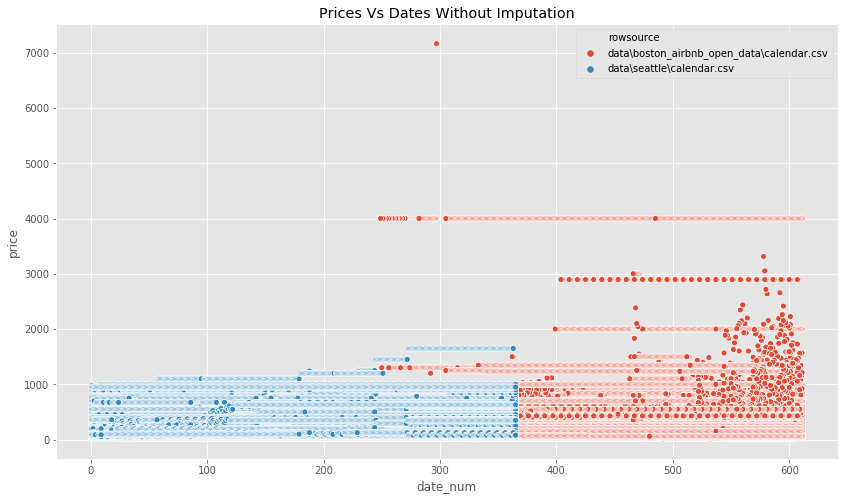

In [63]:
plt.figure(figsize=(14, 8));
plt.title('Prices Vs Dates Without Imputation')
sns.scatterplot(x='date_num', 
                y='price', 
                hue='rowsource', 
                data=calendar);

> **Price Imputation Decision**: 
* Given that the prices are skew to the left, the imputation approach will be the median method on a daily basis, which is not influenced by outliers.
* Given that we were going to remove 42% of the data because of Null prices, I am attempting to mitigate the loss of information by imputing the median on a daily basis, but I am leaving a category for those values that were imputated for the model to recognize those. Perhaps it will be beneficial.
* Another idea is to pass a test set that was not imputated to see if the imputation caused overfitting. I will be able to know what was imputated by looking at the imputed_price column.

### <li> Preparing Data for Analysis: Listings Null Analysis

#### Listings Columns With Nulls

In [64]:
# recalling columns with nulls from previous null analysis
listing_null_columns = list(listing_nulls.index.drop('license'))
print(listing_null_columns)

['host_listings_count', 'city', 'host_total_listings_count', 'host_thumbnail_url', 'host_since', 'host_picture_url', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_name', 'property_type', 'beds', 'market', 'bedrooms', 'host_location', 'bathrooms', 'zipcode', 'summary', 'host_neighbourhood', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'neighbourhood', 'host_response_rate', 'host_response_time', 'host_acceptance_rate', 'reviews_per_month', 'last_review', 'first_review', 'review_scores_rating', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'review_scores_checkin', 'review_scores_accuracy', 'space', 'cleaning_fee', 'host_about', 'transit', 'neighborhood_overview', 'notes', 'has_availability', 'jurisdiction_names', 'neighbourhood_group_cleansed', 'security_deposit', 'weekly_price', 'monthly_price', 'house_rules', 'access', 'interaction', 'square_feet']


#### Dropping Listings Columns With all Nulls

In [65]:
listings.dropna(how='all', axis=1, inplace=True)

#### Listings Null Analysis

In [66]:
t_columns = listings.shape[1]
h_columns = listings.isnull().sum(axis=1)
listings.loc[:, 'row_null_pct'] = h_columns/t_columns

In [67]:
def listing_dist(df, bins, title):
    upper_func = lambda x: x.state.str.upper()
    df.assign(state=upper_func)[['state', 'row_null_pct']]\
        .reset_index()\
        .pivot(index='index',
              columns='state',
              values='row_null_pct')\
        .plot.hist(alpha=.5, 
                   bins=bins,
                   figsize=(12, 5),
                   title=title);

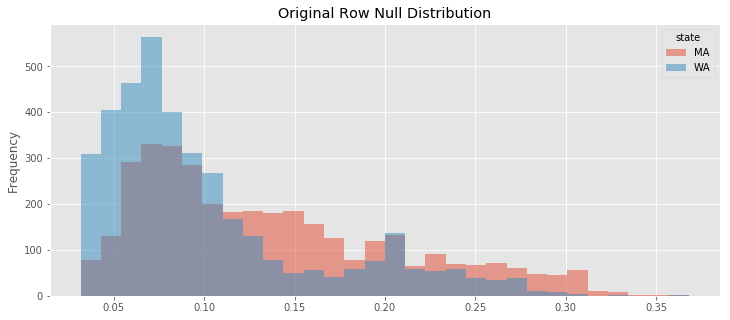

In [68]:
listing_dist(listings, 30, 'Original Row Null Distribution')               

> **Row Null Removal Decision**:
  * Will remove any row that contains more than 30 % of null values
  * Will attempt to imputate anything with less than 30 % of null values
  * What we cannot imputate will be feeded to the model as null dummies

#### Removal of Listings Dataset Rows

In [277]:
# removal threshold
row_remove = listings.row_null_pct <= .50

# removing rows
listings_row_clean = listings[row_remove]

> **Row Null Removal Results**
* The distribution of null still looks skew. But it is better than before.
* The next step is imputations of null values to see if we can make this distribution look more normal.

### Identifying Irrelevant Columns

In [278]:
target_columns = listings_row_clean.isnull().sum().where(lambda x: x>0).dropna().index.tolist()
target_columns

['access',
 'bathrooms',
 'bedrooms',
 'beds',
 'city',
 'cleaning_fee',
 'first_review',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'house_rules',
 'interaction',
 'jurisdiction_names',
 'last_review',
 'market',
 'medium_url',
 'monthly_price',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'notes',
 'property_type',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit',
 'space',
 'square_feet',
 'summary',
 'thumbnail_url',
 'transit',
 'weekly_price',
 'xl_picture_url',
 'z

### Columns to Remove due to Irrelevance

In [279]:
url_columns = listings_row_clean.columns.str.contains('url|pic|name|about|cleansed')
url_columns = listings_row_clean.columns[url_columns].tolist()
url_columns

['host_about',
 'host_has_profile_pic',
 'host_name',
 'host_picture_url',
 'host_thumbnail_url',
 'host_url',
 'jurisdiction_names',
 'listing_url',
 'medium_url',
 'name',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'picture_url',
 'require_guest_profile_picture',
 'thumbnail_url',
 'xl_picture_url']

### Colums to Engineer Provided Info (1) or Not Provided (0)

In [286]:
interest = ['']
df_info = listings_row_clean.filter(regex='access|over|rule|notes|space|summary|transit|interaction')
df_info.head()

,access,house_rules,interaction,neighborhood_overview,notes,space,summary,transit
0,"You will have access to 2 bedrooms, a living r...",Clean up and treat the home the way you'd like...,NaN,"Roslindale is quiet, convenient and friendly. ...",NaN,The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...","The bus stop is 2 blocks away, and frequent. B..."
1,Apt has one more bedroom (which I use) and lar...,Pet friendly but please confirm with me if the...,"If I am at home, I am likely working in my hom...","The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,Plenty of safe street parking. Bus stops a few...
2,"I am living in the apartment during your stay,...","I encourage you to use my kitchen, cooking and...","ABOUT ME: I'm a laid-back, friendly, unmarried...",The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","PUBLIC TRANSPORTATION: From the house, quick p..."
3,The basement has a washer dryer and gym area. ...,- The bathroom and house are shared so please ...,We do live in the house therefore might be som...,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,There are buses that stop right in front of th...
4,You will have access to the front and side por...,"Please no smoking in the house, porch or on th...",I love my city and really enjoy sharing it wit...,"I love the proximity to downtown, the neighbor...",I have one roommate who lives on the lower lev...,"Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",From Logan Airport and South Station you have...


### Columns Left to Imputate or to Engineer

In [287]:
remove_columns = df_info.columns.tolist() + url_columns

In [290]:
target_columns = [x for x in target_columns if x not in remove_columns]
target_columns

['bathrooms',
 'bedrooms',
 'beds',
 'city',
 'cleaning_fee',
 'first_review',
 'has_availability',
 'host_acceptance_rate',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_neighbourhood',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_total_listings_count',
 'last_review',
 'market',
 'monthly_price',
 'neighbourhood',
 'property_type',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit',
 'square_feet',
 'weekly_price',
 'zipcode']

In [293]:
listings_row_clean[target_columns].sample(5).T

,7158,2116,3743,3948,1685
bathrooms,1,1,2.5,1.5,1
bedrooms,0,1,4,1,1
beds,1,1,4,1,1
city,Seattle,Boston,Seattle,Seattle,Boston
cleaning_fee,NaN,$80.00,$50.00,NaN,NaN
first_review,2014-10-26,NaN,NaN,2013-08-09,2015-09-21
has_availability,t,NaN,t,t,NaN
host_acceptance_rate,100%,NaN,100%,100%,64%
host_identity_verified,t,f,t,t,t
host_is_superhost,f,f,f,t,f


In [295]:
listings_row_clean.has_availability.unique()

array([nan, 't'], dtype=object)

## Transformations and Imputations

In [223]:
def correlation_status(column_list):
    """
    Plotting the correlations to keep track of multicollinearity and corrlation with price.
    """
    col_interest = ['id'] + column_list
    price_corr = calendar[['listing_id', 'price']]\
    .merge(listings_row_clean[col_interest],
          left_on='listing_id',
          right_on='id',
          how='left')\
    .drop(['id', 'listing_id'], axis=1)\
    .query("price==price")\
    .astype(float)\
    .corr()
    
    plt.figure(figsize=(14, 10))

    sns.heatmap(price_corr, annot=True, cmap='magma');

### <li> Provided Access

In [71]:
listings_row_clean[['access']].head(10)

,access
0,"You will have access to 2 bedrooms, a living r..."
1,Apt has one more bedroom (which I use) and lar...
2,"I am living in the apartment during your stay,..."
3,The basement has a washer dryer and gym area. ...
4,You will have access to the front and side por...
5,Guests are welcome to share our living room an...
6,I have an electronic keypad so arrival time ca...
7,Amenities include an evening snack upon arriva...
8,NaN
9,NaN


####  <ol> Imputing Access as AccessInfoProvided

In [72]:
# creating the new column for provided access information
listings_row_clean.loc[:, 'AccessInfoProvided'] = listings_row_clean.access\
    .where(lambda x: x.isnull(), 1).fillna(0).copy()

In [73]:
# dropping the source of the new column
listings_row_clean.drop('access', axis=1, inplace=True)

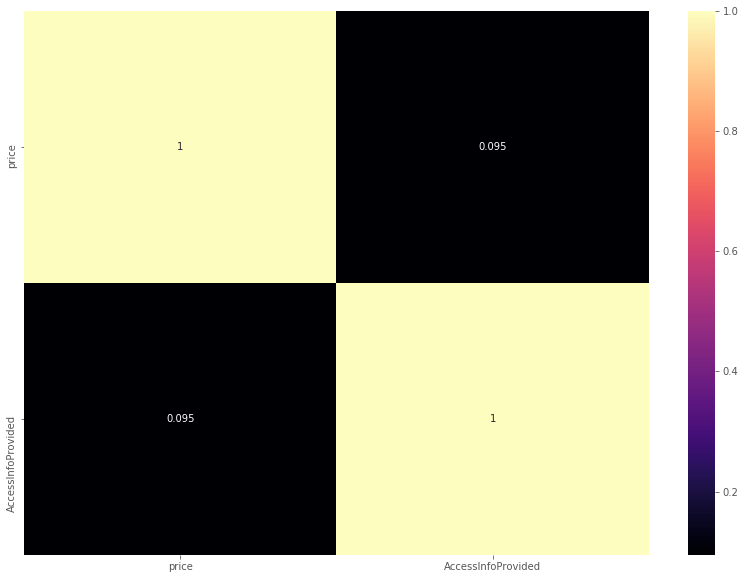

In [224]:
correlation_columns = ['AccessInfoProvided']
correlation_status(correlation_columns)

### <li> Number of Bathrooms, Bedrooms, and Beds

In [75]:
bathroom_to_impute = listings_row_clean.groupby('bedrooms').bathrooms
bathroom_to_impute = bathroom_to_impute.apply(lambda x: x.mode()).to_frame()
bathroom_to_impute

bathrooms
bedrooms             
0.0      0        1.0
1.0      0        1.0
2.0      0        1.0
3.0      0        2.0
4.0      0        2.0
5.0      0        3.5
6.0      0        3.0
         1        3.5
7.0      0        4.0

In [76]:
# for listings with 6 bedrooms imput 3 bathrooms
keep = bathroom_to_impute.reset_index().level_1 == 0
bathroom_to_impute = bathroom_to_impute.reset_index()[keep].drop('level_1', axis=1)
bathroom_to_impute

,bedrooms,bathrooms
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,2.0
4,4.0,2.0
5,5.0,3.5
6,6.0,3.0
8,7.0,4.0


In [77]:
bathroom_map = bathroom_to_impute.set_index('bedrooms').T.to_dict('records')[0]

In [78]:
# missing bedrooms counts that have null values
listings_row_clean.query("bathrooms!=bathrooms")\
    .groupby('bedrooms')\
    .size()\
    .to_frame('couts')

,couts
bedrooms,
1.0,26
2.0,4


In [79]:
bedrooms_to_impute = listings_row_clean.groupby('bathrooms').bedrooms
bedrooms_to_impute = bedrooms_to_impute.apply(lambda x: x.mode()).to_frame()
bedrooms_to_impute.reset_index().drop('level_1', axis=1)

,bathrooms,bedrooms
0,0.0,1.0
1,0.5,1.0
2,1.0,1.0
3,1.5,1.0
4,2.0,2.0
5,2.5,3.0
6,3.0,3.0
7,3.5,4.0
8,4.0,4.0
9,4.5,5.0


In [80]:
# missing bathroom counts that have null values
listings_row_clean.query("bedrooms!=bedrooms")\
    .groupby('bathrooms')\
    .size()\
    .to_frame('couts')

,couts
bathrooms,
1.0,16


In [81]:
beds_to_impute = listings_row_clean.groupby(['bedrooms']).beds
beds_to_impute = beds_to_impute.apply(lambda x: x.mode()).to_frame()
beds_to_impute.reset_index().drop('level_1', axis=1)

,bedrooms,beds
0,0.0,1.0
1,1.0,1.0
2,2.0,2.0
3,3.0,3.0
4,4.0,4.0
5,5.0,5.0
6,6.0,6.0
7,6.0,9.0
8,7.0,10.0


In [82]:
# missing beds counts that have null values
listings_row_clean.query("beds!=beds")\
    .groupby('bedrooms')\
    .size()\
    .to_frame('couts')

,couts
bedrooms,
1.0,10


> **Bedroom, Bathroom, Beds Imputing Decission**:
* The mode bathrooms grouped by bedrooms is going to be imputed for the bathrooms.
* The mode bedrooms grouped by bathrooms is going to be imputed for the bedrooms.
* The mode beds grouped by bedrooms is going to be imputed for the beds.

#### <ol> Imputing Mode of Bedrooms and Bathrooms

In [83]:
# imputing bathrooms
listings_row_clean.loc[:, 'bathrooms'] = listings_row_clean.loc[:, 'bathrooms'].fillna(1)

# imputing bedrooms
listings_row_clean.loc[:, 'bedrooms'] = listings_row_clean.loc[:, 'bedrooms'].fillna(1)

# imputing beds
listings_row_clean.loc[:, 'beds'] = listings_row_clean.loc[:, 'beds'].fillna(1)

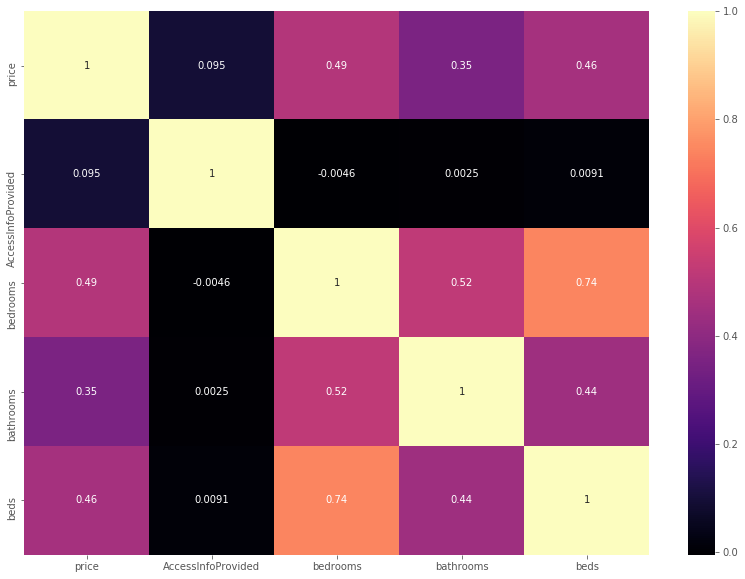

In [225]:
house_related_columns = ['bedrooms', 'bathrooms', 'beds']
correlation_columns = correlation_columns + house_related_columns
correlation_status(correlation_columns)

### <li> City

In [226]:
listings_row_clean.columns

Index(['accommodates', 'amenities', 'availability_30', 'availability_365',
       'availability_60', 'availability_90', 'bathrooms', 'bed_type',
       'bedrooms', 'beds', 'calculated_host_listings_count',
       'calendar_last_scraped', 'calendar_updated', 'cancellation_policy',
       'city', 'cleaning_fee', 'country', 'country_code', 'description',
       'experiences_offered', 'extra_people', 'guests_included',
       'has_availability', 'host_about', 'host_acceptance_rate',
       'host_has_profile_pic', 'host_id', 'host_identity_verified',
       'host_is_superhost', 'host_listings_count', 'host_location',
       'host_name', 'host_neighbourhood', 'host_picture_url',
       'host_response_rate', 'host_response_time', 'host_since',
       'host_thumbnail_url', 'host_total_listings_count', 'host_url',
       'host_verifications', 'house_rules', 'id', 'instant_bookable',
       'interaction', 'is_location_exact', 'jurisdiction_names',
       'last_scraped', 'latitude', 'listing_url'

In [228]:
city_related_col = ['city', 'zipcode', 'latitude', 'longitude', 'neighbourhood',
                    'street', 'smart_location']
listings_row_clean[city_related_col].query("city!=city")

,city,zipcode,latitude,longitude,neighbourhood,street,smart_location


> **City Imputation Decission**:
* Given by the related latitude and longitude, both missing values are related to Chestnut Hill city in Massachusets.

#### <ol> Imputing City

In [229]:
listings_row_clean.loc[:, 'city'] = listings_row_clean.loc[:, 'city'].fillna('Chestnut Hill')

In [231]:
dummy_tracker = ['city']

### <li> Cleaning Fee

#### <ol> Investigating Cleaning Fee Null Relations

In [232]:
listings_row_clean.cleaning_fee[:10]

0    35.0
1    10.0
2     0.0
3    50.0
4    15.0
5    30.0
6     0.0
7    10.0
8     0.0
9    50.0
Name: cleaning_fee, dtype: float64

#### <ol> Cleaning Cleaning Fee

In [233]:
clefee_func = lambda x: x.replace('$', '') if not pd.isnull(x) else x
listings_row_clean.loc[:, 'cleaning_fee'] = listings_row_clean\
    .cleaning_fee\
    .apply(clefee_func)\
    .astype(float)

AttributeError: 'float' object has no attribute 'replace'

#### <ol> Checking Importance of Cleaning Fee

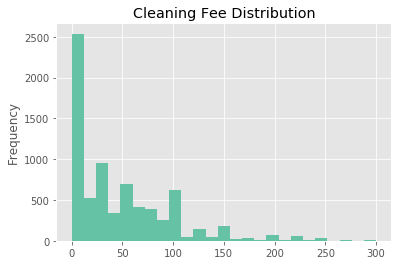

In [234]:
listings_row_clean.cleaning_fee\
    .plot.hist(bins=25, 
               title='Cleaning Fee Distribution',
               cmap='Set2');

In [235]:
min_clea = listings_row_clean.cleaning_fee.min()
max_clea = listings_row_clean.cleaning_fee.max()
mid_clea = (max_clea - min_clea)/2
grouper = pd.cut(listings_row_clean.cleaning_fee, bins=[min_clea, mid_clea, max_clea])
listings_row_clean.groupby(grouper).size().to_frame('counts')

,counts
cleaning_fee,
"(0.0, 150.0]",4998
"(150.0, 300.0]",268


> **Cleaning Fee Imputation Decision**:
* Since there is no 0 fees recorded, I am assuming the null values indicates where the listing has no cleaning fee.

#### <ol> Imputing Cleaning Fee

In [95]:
cleanin_median = listings_row_clean.cleaning_fee.median()
listings_row_clean.loc[:, 'cleaning_fee'] = listings_row_clean\
    .cleaning_fee.fillna(0)

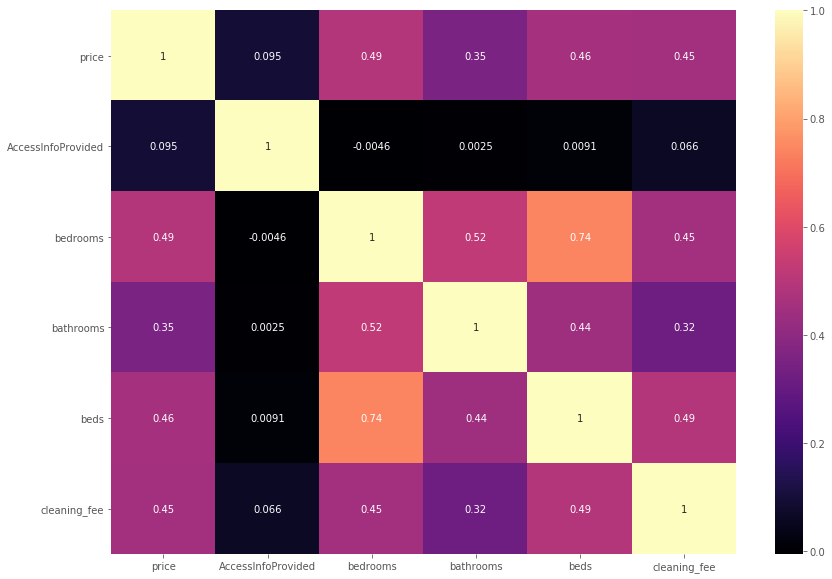

In [236]:
correlation_columns = correlation_columns + ['cleaning_fee']
correlation_status(correlation_columns)

### <li> First Review, Last Review

In [191]:
# Columns related to reviews
review_columns = listings_row_clean.columns[listings_row_clean.columns.str.contains('review')]
review_columns = ['id'] + review_columns.tolist()

df_review_columns = listings_row_clean[review_columns]

#### <ol> Investigating Null Values

In [192]:
df_review_columns.query("number_of_reviews!=0").isnull().sum().to_frame('missing')\
    .style.set_caption('Where Number of Reviews is not 0.')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,98
review_scores_checkin,95
review_scores_cleanliness,88
review_scores_communication,86
review_scores_location,94
review_scores_rating,77


In [193]:
df_review_columns.query("number_of_reviews==0").isnull().sum().to_frame('missing')\
    .style.set_caption('Where Number of Reviews is 0')

,missing
id,0
first_review,1383
last_review,1383
number_of_reviews,0
review_scores_accuracy,1383
review_scores_checkin,1383
review_scores_cleanliness,1383
review_scores_communication,1383
review_scores_location,1383
review_scores_rating,1383


In [195]:
df_review_columns.query("number_of_reviews!=0")\
    .merge(reviews.groupby('listing_id', as_index=False).sum(),
           left_on='id',
           right_on='listing_id',
           how='left',
           suffixes=['', '_reviews']).isnull().sum().to_frame('missing')\
    .style.set_caption('Where Number of Reviews not 0 and merge reviews')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,98
review_scores_checkin,95
review_scores_cleanliness,88
review_scores_communication,86
review_scores_location,94
review_scores_rating,77


In [196]:
df_review_columns.head()

,id,first_review,last_review,number_of_reviews,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month
0,12147973,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3075044,2014-06-01,2016-08-13,36,10.0,10.0,9.0,10.0,9.0,94.0,9.0,1.30
2,6976,2009-07-19,2016-08-05,41,10.0,10.0,9.0,10.0,9.0,98.0,10.0,0.47
3,1436513,2016-08-28,2016-08-28,1,10.0,10.0,10.0,10.0,10.0,100.0,10.0,1.00
4,7651065,2015-08-18,2016-09-01,29,10.0,10.0,10.0,10.0,9.0,99.0,10.0,2.25


> **Reviews imputations decission**:
* Where the  number of reviews is 0, all review data is Null. This means that these Nulls are meaningfull for the analysis and should be set as dummies to identify when listings have no ratings.
* Where the number of reviews is not 0, there are some review scores that are null. However, the revies dataset fills these nulls.
* Given that the reviews dataset, we could apply natural language processing to predict the missing ratings.
* Since there are no substantial missing values for these scores, we are leaving the nulls for now. We can later apply NLP to predict them if the predicting model does not perform as desired.
* We are removing first_review and last_review and replacing it with review_lag to account for the dates between the first review and the last review.
* Another option is to engineer the rate of reviews by dividing the review_lag by the number_of_reviews. We are doing the column here, but if it perform worst than the two derived columns, we will drop it.

#### <ol> Engineering review_lag and review_rate

In [204]:
# creating the lag between first and last review
day_func = lambda x: x.days
diff_func = lambda x: (pd.to_datetime(x.last_review) - pd.to_datetime(x.first_review)).apply(day_func)
reate_func = lambda x: (x.review_lag/x.number_of_reviews)

# engineering review lag
listings_row_clean = listings_row_clean.assign(review_lag=diff_func)

# engineering review rate
listings_row_clean = listings_row_clean.assign(review_rate=reate_func)

# dropping fist_review and last_review
listings_row_clean.drop(['first_review', 'last_review'], axis=1, inplace=True)

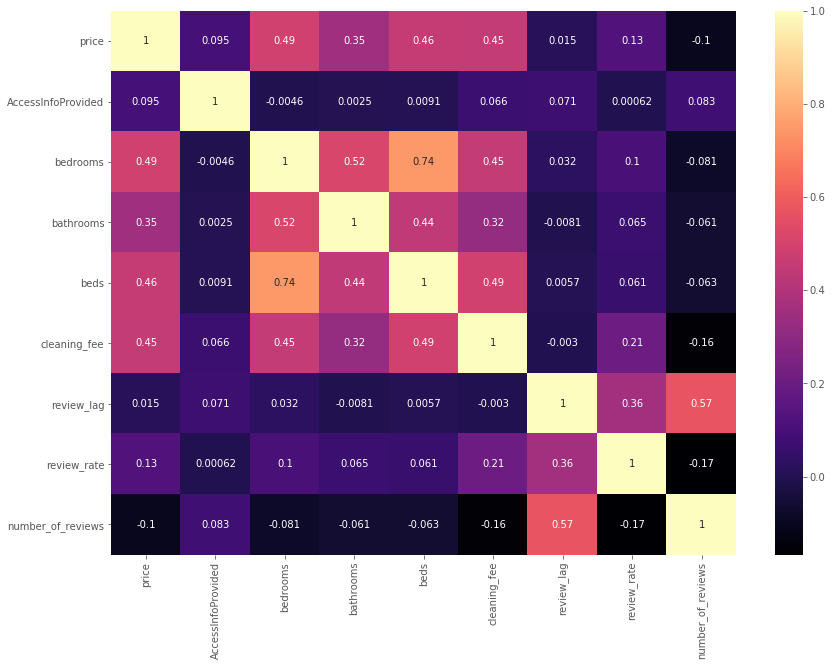

In [237]:
review_targets = ['review_lag', 'review_rate', 'number_of_reviews']
correlation_columns = correlation_columns + review_targets
correlation_status(correlation_columns)

### <li> Preparing Data for Analysis: Starting Calendar Imputations

In [249]:
calendar_imputed = calendar.copy()

#### Null Price Imputations

In [250]:
filter_bos_cond = (calendar.rowsource == 'data\\boston_airbnb_open_data\\calendar.csv')
filter_sea_cond = (calendar.rowsource == 'data\\seattle\\calendar.csv')

##### <ol> Boston Imputation

In [163]:
calendar[filter_bos_cond].query("date == '2017-09-05'").price.describe()

count    1801.000000
mean      190.804553
std       182.108034
min        20.000000
25%        80.000000
50%       150.000000
75%       249.000000
max      4000.000000
Name: price, dtype: float64

In [164]:
# daily medians to impute for boston
bos_medians = calendar[filter_bos_cond].groupby(['rowsource', 'date']).price.transform('median')

In [ ]:
# boston price imputation
calendar_imputed.loc[filter_bos_cond, 'price'] = calendar[filter_bos_cond].price.fillna(bos_medians)

In [ ]:
# Validating imputation
calendar_imputed.query("date=='2017-09-05' and nan_grp=='MissingValue'").head(1)

##### <ol> Seattle Imputation

In [ ]:
calendar[filter_sea_cond].query("date == '2016-09-05'").price.describe()

In [ ]:
# daily medians to impute for boston
sea_medians = calendar[filter_sea_cond].groupby(['rowsource', 'date']).price.transform('median')

# boston price imputation
calendar_imputed.loc[filter_sea_cond, 'price'] = calendar[filter_sea_cond].price.fillna(sea_medians)

In [ ]:
# Validating imputation
calendar_imputed.query("date=='2016-09-05' and nan_grp=='MissingValue'").head(1)

##### <ol> imputed_price Category

In [ ]:
# mapping the labels for the imputed_price category
imputed_price = {'MissingValue': 1, 'ProvidedValue': 0}

# creating category
calendar_imputed['imputed_price'] = calendar_imputed.nan_grp.map(imputed_price)

In [ ]:
# validating imputed_price category
calendar_imputed.query("imputed_price==1").nan_grp.unique()

In [ ]:
# dropping nan_grp and other unecessary columns
drop_from_calendar = ['rowsource', 'nan_grp', 'source_grp']
calendar_imputed.drop(drop_from_calendar, axis=1, inplace=True)

In [ ]:
calendar_imputed.head()

# Analysis & Visualizations

# Modeling & Visualizations

# Evaluating Results

# Conclussion

In [ ]:
sns.scatterplot

In [478]:
os.system("git add .")

0

In [479]:
os.system('git commit -m "Feature engineering first review to last review days"')

0

In [480]:
os.system("git push")

0